In [1]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; import seaborn
%matplotlib inline

In [2]:
def quantile_1D(data, weights, quantile):
    # Check the data
    if not isinstance(data, np.matrix) :
        data = np.asarray(data)
    if not isinstance(weights, np.matrix) :
        weights = np.asarray(weights)
    nd = data.ndim
    if ((quantile > 1.) or (quantile < 0.)):
        raise ValueError("quantile must have a value between 0. and 1.")
    # Sort the data
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    # Compute the auxiliary arrays
    Sn = np.cumsum(sorted_weights)
    Pn = (Sn-0.5*sorted_weights)/np.sum(sorted_weights)
    # Get the value of the weighted median
    return np.interp(quantile, Pn, sorted_data)


def quantile(data, weights, quantile):
    nd = data.ndim
    if nd == 1:
        return quantile_1D(data, weights, quantile)
    elif nd > 1:
        n = data.shape
        imr = data.reshape((np.prod(n[:-1]), n[-1]))
        result = np.apply_along_axis(quantile_1D, -1, imr, weights, quantile)
        return result.reshape(n[:-1])

In [3]:
wh1 = pd.read_stata("C:/Users/tew207/Desktop/PhD_Data/WAS/was_wave_1_hhold_eul.dta")
wp1 = pd.read_stata("C:/Users/tew207/Desktop/PhD_Data/WAS/was_wave_1_person_eul.dta")
w1 = pd.merge(wh1, wp1, on="casew1")
w1.sort('casew1', inplace=True)
w1.reset_index(inplace=True)


wh2 = pd.read_stata("C:/Users/tew207/Desktop/PhD_Data/WAS/was_wave_2_hhold_eul.dta")
wp2 = pd.read_stata("C:/Users/tew207/Desktop/PhD_Data/WAS/was_wave_2_person_eul.dta", convert_categoricals=False)
w2 = pd.merge(wh2, wp2, on="CASEW2")
w2.sort('CASEW2', inplace=True)
w2.reset_index(inplace=True)


wh3 = pd.read_stata("C:/Users/tew207/Desktop/PhD_Data/WAS/was_wave_3_hhold_eul.dta")
wp3 = pd.read_stata("C:/Users/tew207/Desktop/PhD_Data/WAS/was_wave_3_person_eul.dta")
w3 = pd.merge(wh3, wp3, on="CASEw3")
w3 = w3[~np.isnan(w3.w3xswgt_x)]
w3.sort('CASEw3', inplace=True)
w3.reset_index(inplace=True)
wh3 = wh3[~np.isnan(wh3.w3xswgt)]

The ONS gives household earned income as £27,700 for the 2006-2008 period ([Source](http://doc.ukdataservice.ac.uk/doc/6709/mrdoc/pdf/6709report_2006_2008.pdf)), so we'll use this to normalize wealth in the first wave.
For waves 2 and 3, we need to adjust for the change in income in the years 2008 to 2012. The ONS has data on the growth in real average weekly earnings [here](http://www.ons.gov.uk/ons/rel/lms/labour-market-statistics/september-2015/dataset--earnings.html). Given that the index was 114.8 in 2006, 116.9 in 2007, and 117 in 2008, we can simply rebase the wage in 2008Q3 to the average value of the index in those years to get a smooth transition.
For wave 3, household net income is provided in the WAS itself, so we can use this value directly (although one should note that it is substantially higher than BHPS or any other figures on net income!)

In [4]:
# This is 2008Q3 to 2012Q2
quarterly_wages = np.array([116.3, 116.9, 117.1, 117.2, 116.1, 115.8, 115.5, 114.8, 115.1, 
                         114.5, 113.3, 112.5, 111.8, 111.6, 111.3, 111.4])/((114.8+116.9+117)/3.0)

real_wage = np.zeros(len(quarterly_wages) + 1)
real_wage[0] = 27700.0
for i in range(1,len(real_wage)):
    real_wage[i] = real_wage[0]*(quarterly_wages[i-1])
    
avg_wage_w2 = np.mean(real_wage[0:8])
avg_wage_w3 = np.mean(real_wage[9:16])

In [24]:
w1['w_over_y'] = w1.TotWlthW1/27700.0
w2['w_over_y'] = w2.TotWlthW2/avg_wage_w2
w3['w_over_y'] = w3.TotWlthW3/(sum(wh3.DVTotNIRW3*wh3.w3xswgt/sum(wh3.w3xswgt)))

In [25]:
prime_age = ["25-34","35-44","45-54"]
prime1 = (w1.ISHRPW1=="Is the HRP") & (w1.HRPDVAge9W1.isin(prime_age))
prime2 = (w2.ISHRPW2==1) & (w2.HRPDVAge9W2.isin(prime_age))
#prime3 = (w3. == ) & (w3.HRPDVAge9W3.isin(prime_age))
young1 = (w1.ISHRPW1=="Is the HRP") & (w1.HRPDVAge9W1=="25-34")
middle1 = (w1.ISHRPW1=="Is the HRP") & (w1.HRPDVAge9W1=="35-44")
old1 = (w1.ISHRPW1=="Is the HRP") & (w1.HRPDVAge9W1=="45-54")
young2 = (w2.ISHRPW2==1) & (w2.HRPDVAge9W2=="25-34")
middle2 = (w2.ISHRPW2==1) & (w2.HRPDVAge9W2=="35-44")
old2 = (w2.ISHRPW2==1) & (w2.HRPDVAge9W2=="45-54")
#young3 = (w3. == ) & (w3.HRPDVAge9W3=="25-34")
#middle3 = (w3. == ) & (w3.HRPDVAge9W3=="35-44")
#old3 = (w3. == ) & (w3.HRPDVAge9W3=="45-54")

full_pctl1 = np.zeros(99)
full_pctl2 = np.zeros(99)
full_pctl3 = np.zeros(99)
prime_pctl1 = np.zeros(99)
prime_pctl2 = np.zeros(99)
#prime_pctl3 = np.zeros(99)
young_pctl1 = np.zeros(99)
middle_pctl1 = np.zeros(99)
old_pctl1 = np.zeros(99)
young_pctl2 = np.zeros(99)
middle_pctl2 = np.zeros(99)
old_pctl2 = np.zeros(99)
#young_pctl3 np.zeros(99)
#middle_pctl3 np.zeros(99)
#old_pctl3 np.zeros(99)
for i in range(0,99):
    full_pctl1[i] = quantile(w1.w_over_y, w1.XS_wgtW1_x, (i+1)/100.0)
    full_pctl2[i] = quantile(w2.w_over_y, w2.XS_calwgtW2_x, (i+1)/100.0)
    full_pctl3[i] = quantile(w3.w_over_y, w3.w3xswgt_x, (i+1)/100.0)
    prime_pctl1[i] = quantile(w1[prime1].w_over_y, w1[prime1].XS_wgtW1_x, (i+1)/100.0)
    prime_pctl2[i] = quantile(w2[prime2].w_over_y, w2[prime2].XS_calwgtW2_x, (i+1)/100.0)
    young_pctl1[i] = quantile(w1[young1].w_over_y, w1[young1].XS_wgtW1_x, (i+1)/100.0)
    young_pctl2[i] = quantile(w2[young2].w_over_y, w2[young2].XS_calwgtW2_x, (i+1)/100.0)
    #young_pctl3[i] = quantile(w3[young3].w_over_y, w3[young].w3xswgt_x, (i+1)/100.0)
    middle_pctl1[i] = quantile(w1[middle1].w_over_y, w1[middle1].XS_wgtW1_x, (i+1)/100.0)
    middle_pctl2[i] = quantile(w2[middle2].w_over_y, w2[middle2].XS_calwgtW2_x, (i+1)/100.0)
    #middle_pctl3[i] = quantile(w3[middle3].w_over_y, w3[middle3].w3xswgt_x, (i+1)/100.0)
    old_pctl1[i] = quantile(w1[old1].w_over_y, w1[old1].XS_wgtW1_x, (i+1)/100.0)
    old_pctl2[i] = quantile(w2[old2].w_over_y, w2[old2].XS_calwgtW2_x, (i+1)/100.0)
    #old_pctl3[i] = quantile(w3[old3].w_over_y, w3[old3].w3xswgt_x, (i+1)/100.0)

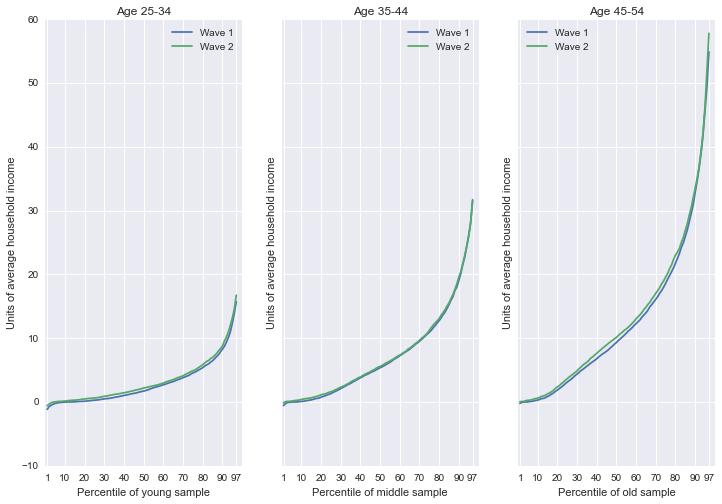

In [26]:
fig, ax = plt.subplots(1,3, figsize=(12,8), sharey = True)
ax[0].plot(range(1,98), young_pctl1[0:97], label = "Wave 1")                            
ax[0].plot(range(1,98),young_pctl2[0:97], label = "Wave 2")
ax[0].set_xticks([1,10,20,30,40,50,60,70,80,90,97])
ax[0].set_xticklabels([1,10,20,30,40,50,60,70,80,90,97])
ax[0].set_ylabel("Units of average household income")
ax[0].set_xlabel("Percentile of young sample")
ax[0].legend(loc="best")
ax[0].set_title("Age 25-34")
ax[1].plot(range(1,98), middle_pctl1[0:97], label = "Wave 1")                            
ax[1].plot(range(1,98),middle_pctl2[0:97], label = "Wave 2")
ax[1].set_xticks([1,10,20,30,40,50,60,70,80,90,97])
ax[1].set_xticklabels([1,10,20,30,40,50,60,70,80,90,97])
ax[1].set_ylabel("Units of average household income")
ax[1].set_xlabel("Percentile of middle sample")
ax[1].legend(loc="best")
ax[1].set_title("Age 35-44")
ax[2].plot(range(1,98), old_pctl1[0:97], label = "Wave 1")                            
ax[2].plot(range(1,98),old_pctl2[0:97], label = "Wave 2")
ax[2].set_xticks([1,10,20,30,40,50,60,70,80,90,97])
ax[2].set_xticklabels([1,10,20,30,40,50,60,70,80,90,97])
ax[2].set_ylabel("Units of average household income")
ax[2].set_xlabel("Percentile of old sample")
ax[2].legend(loc="best")
ax[2].set_title("Age 45-54");

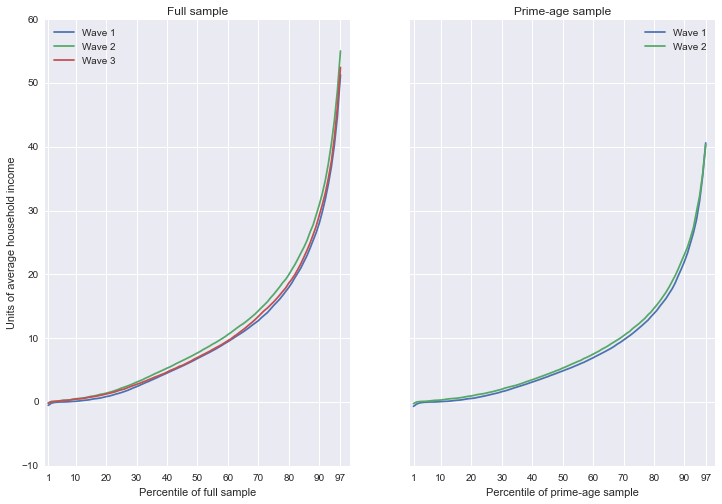

In [27]:
fig, ax = plt.subplots(1,2, figsize=(12,8), sharey = True)
ax[0].plot(range(1,98), full_pctl1[0:97], label = "Wave 1")                            
ax[0].plot(range(1,98),full_pctl2[0:97], label = "Wave 2")
ax[0].plot(range(1,98),full_pctl3[0:97], label = "Wave 3")
ax[0].set_xticks([1,10,20,30,40,50,60,70,80,90,97])
ax[0].set_xticklabels([1,10,20,30,40,50,60,70,80,90,97])
ax[0].set_ylabel("Units of average household income")
ax[0].set_xlabel("Percentile of full sample")
ax[0].legend(loc="best")
ax[0].set_title("Full sample")
ax[1].plot(range(1,98), prime_pctl1[0:97], label = "Wave 1")
ax[1].plot(range(1,98), prime_pctl2[0:97], label = "Wave 2")
ax[1].set_xticks([1,10,20,30,40,50,60,70,80,90,97])
ax[1].set_xticklabels([1,10,20,30,40,50,60,70,80,90,97])
ax[1].set_xlabel("Percentile of prime-age sample")
ax[1].set_title("Prime-age sample")
ax[1].legend(loc="best");

In [28]:
import h5py

output = h5py.File('C:/Users/tew207/Desktop/WAS_percentiles.h5', 'w')
output.create_dataset('W1_full', data=full_pctl1)
output.create_dataset('W2_full', data=full_pctl2)
output.create_dataset('W3_full', data=full_pctl3)
output.create_dataset('W1_prime', data=prime_pctl1)
output.create_dataset('W2_prime', data=prime_pctl2)
output.create_dataset('W1_young', data=young_pctl1)
output.create_dataset('W1_middle', data=middle_pctl1)
output.create_dataset('W1_old', data=middle_pctl1)
output.create_dataset('W2_young', data=young_pctl2)
output.create_dataset('W2_middle', data=middle_pctl2)
output.create_dataset('W2_old', data=middle_pctl2)
output.close()